## Data collection

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
ls data/words/a01/a01-000u

a01-000u-00-00.png  a01-000u-02-00.png  a01-000u-03-04.png  a01-000u-05-03.png
a01-000u-00-01.png  a01-000u-02-01.png  a01-000u-03-05.png  a01-000u-05-04.png
a01-000u-00-02.png  a01-000u-02-02.png  a01-000u-03-06.png  a01-000u-05-05.png
a01-000u-00-03.png  a01-000u-02-03.png  a01-000u-04-00.png  a01-000u-05-06.png
a01-000u-00-04.png  a01-000u-02-04.png  a01-000u-04-01.png  a01-000u-05-07.png
a01-000u-00-05.png  a01-000u-02-05.png  a01-000u-04-02.png  a01-000u-05-08.png
a01-000u-00-06.png  a01-000u-02-06.png  a01-000u-04-03.png  a01-000u-06-00.png
a01-000u-01-00.png  a01-000u-02-07.png  a01-000u-04-04.png  a01-000u-06-01.png
a01-000u-01-01.png  a01-000u-02-08.png  a01-000u-04-05.png  a01-000u-06-02.png
a01-000u-01-02.png  a01-000u-03-00.png  a01-000u-04-06.png  a01-000u-06-03.png
a01-000u-01-03.png  a01-000u-03-01.png  a01-000u-05-00.png  a01-000u-06-04.png
a01-000u-01-04.png  a01-000u-03-02.png  a01-000u-05-01.png  a01-000u-06-05.png
a01-000u-01-05.png  a01-000u-03-03.png  a01-000u-05-

Preview how the dataset is organized. Lines prepended by "#" are just metadata information.

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [ ]:
# !head -20 tagset.txt
!ls

data  IAM_Words  IAM_Words.zip	sample_data


## Imports

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset splitting

In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)
# print(words_list[:100],end=" ")
np.random.shuffle(words_list)

In [ ]:
len(words),len(words_list)

(115338, 96456)

In [ ]:
words[:30]

['#--- words.txt ---------------------------------------------------------------#\n',
 '#\n',
 '# iam database word information\n',
 '#\n',
 '# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A\n',
 '#\n',
 '#     a01-000u-00-00  -> word id for line 00 in form a01-000u\n',
 '#     ok              -> result of word segmentation\n',
 '#                            ok: word was correctly\n',
 '#                            er: segmentation of word can be bad\n',
 '#\n',
 '#     154             -> graylevel to binarize the line containing this word\n',
 '#     1               -> number of components for this word\n',
 '#     408 768 27 51   -> bounding box around this word in x,y,w,h format\n',
 '#     AT              -> the grammatical tag for this word, see the\n',
 '#                        file tagset.txt for an explanation\n',
 '#     A               -> the transcription for this word\n',
 '#\n',
 'a01-000u-00-00 ok 154 408 768 27 51 AT A\n',
 'a01-000u-00-01 ok 154 507 766 213 48 NN M

We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [ ]:
split_idx = int(0.9 * len(words_list))
print(f"Split index : {split_idx}\n")
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}\n")

print(f"Assert Words list : {len(words_list)}")

Split index : 86810

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823

Assert Words list : 96456


In [ ]:
len(test_samples)

4823

## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

In [ ]:
base_image_path = os.path.join(base_path, "words")
print(f"Base image path : {base_image_path}")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

Base image path : data/words


In [ ]:
# train_img_paths

for i in range(15):
  print(f"Path : {train_img_paths[i]} --&&-- Label : {train_labels[i]}")
  # Same format for validation and testing images

Path : data/words/e04/e04-030/e04-030-04-08.png --&&-- Label : e04-030-04-08 ok 170 1489 1499 120 39 JJ sure
Path : data/words/k02/k02-102/k02-102-05-03.png --&&-- Label : k02-102-05-03 ok 182 836 1623 69 52 PP3A he
Path : data/words/a01/a01-082u/a01-082u-01-04.png --&&-- Label : a01-082u-01-04 ok 172 1582 1043 234 88 IN during
Path : data/words/m01/m01-000/m01-000-07-00.png --&&-- Label : m01-000-07-00 ok 196 339 1998 75 107 INO of
Path : data/words/g01/g01-031/g01-031-07-06.png --&&-- Label : g01-031-07-06 ok 152 1912 2038 167 59 NN booty
Path : data/words/f07/f07-081b/f07-081b-01-06.png --&&-- Label : f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy
Path : data/words/n03/n03-082/n03-082-04-03.png --&&-- Label : n03-082-04-03 ok 165 992 1414 118 135 NN boy
Path : data/words/g06/g06-018c/g06-018c-04-05.png --&&-- Label : g06-018c-04-05 ok 182 1298 1438 96 58 ATI The
Path : data/words/g06/g06-011j/g06-011j-06-06.png --&&-- Label : g06-011j-06-06 ok 182 1222 1785 146 95 CC and
Path :

In [ ]:
# test_img_paths

for i in range(15):
  print(f"Path : {test_img_paths[i]} --&&-- Label : {test_labels[i]}")
  # Same format for validation and testing images

Path : data/words/g01/g01-067/g01-067-03-02.png --&&-- Label : g01-067-03-02 ok 152 832 1308 286 82 VBN altered
Path : data/words/m04/m04-093/m04-093-07-01.png --&&-- Label : m04-093-07-01 ok 168 389 1987 154 75 RN Here
Path : data/words/l04/l04-179/l04-179-05-00.png --&&-- Label : l04-179-05-00 ok 169 329 1618 7 22 *' '
Path : data/words/b05/b05-038/b05-038-01-00.png --&&-- Label : b05-038-01-00 ok 151 329 879 147 69 ATI the
Path : data/words/l04/l04-163/l04-163-04-08.png --&&-- Label : l04-163-04-08 ok 158 1881 1448 35 54 PP3 It
Path : data/words/l07/l07-135/l07-135-07-04.png --&&-- Label : l07-135-07-04 ok 180 1619 2194 106 72 IN up
Path : data/words/e04/e04-022/e04-022-06-05.png --&&-- Label : e04-022-06-05 ok 172 1455 1815 204 152 NNS edges
Path : data/words/e02/e02-014/e02-014-01-00.png --&&-- Label : e02-014-01-00 ok 195 302 903 139 67 ATI The
Path : data/words/e04/e04-022/e04-022-02-03.png --&&-- Label : e04-022-02-03 ok 173 1015 1120 283 120 NN position
Path : data/words/e04/e

Then we prepare the ground-truth labels.

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
print()
for i in range(20):
  print(train_labels_cleaned[i],end=" ")

Maximum length:  21
Vocab size:  78

sure he during of booty gastronomy boy The and in his flying presented No as few work of items took 

In [ ]:
for j in characters:
  print(j,end=" ")

! " # & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z 

Now we clean the validation and the test labels as well.

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

for i in range(15):
  print(validation_labels_cleaned[i],end=" ")

print()
for i in range(15):
  print(test_labels_cleaned[i],end=" ")

able full . act you National - abyss said in Aviation . in Ministry the 
altered Here ' the It up edges The position scratched officer's to late wanted , 

### Building the character vocabulary

Keras provides different preprocessing layers to deal with different modalities of data.
[This guide](https://keras.io/guides/preprocessing_layers/) provides a comprehensive introduction.
Our example involves preprocessing labels at the character
level. This means that if there are two labels, e.g. "cat" and "dog", then our character
vocabulary should be {a, c, d, g, o, t} (without any special tokens). We use the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/)
layer for this purpose.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

num_to_char

### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.

In [ ]:
# Distortion is an alteration of the original shape or form of something.

# This function can be used to resize our images
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


If we just go with the plain resizing then the images would look like so:

![](https://i.imgur.com/eqq3s4N.png)

Notice how this resizing would have introduced unnecessary stretching.

### Putting the utilities together

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


## Prepare `tf.data.Dataset` objects

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

train_ds
test_ds.element_spec["image"]

TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None)

## Visualize a few samples

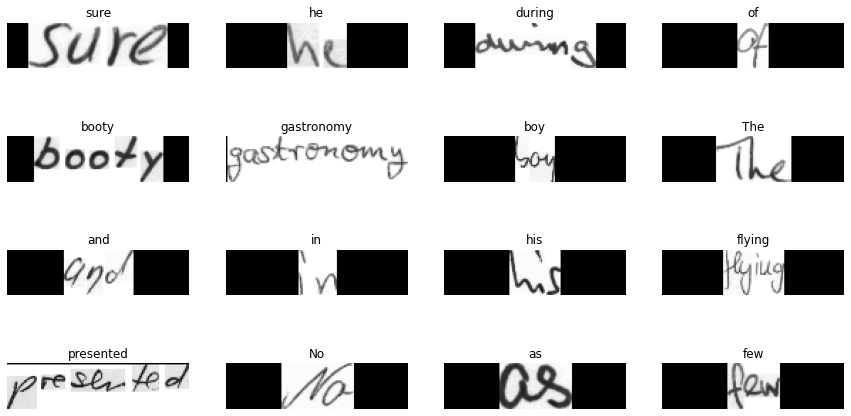

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

You will notice that the content of original image is kept as faithful as possible and has
been padded accordingly.

## Model

Our model will use the CTC loss as an endpoint layer. For a detailed understanding of the
CTC loss, refer to [this post](https://distill.pub/2017/ctc/).

In [ ]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        # accuracy = model.evaluate(y_true, y_pred, verbose = 0) 
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="Handwriting_Recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    # accuracy = model.evaluate(y_true, y_pred, verbose = 0) 
    model.compile(optimizer=opt,metrics=[keras.metrics.Accuracy()])
    return model


# Get the model.
model = build_model()
print("Model : ")
model.summary()

Model : 
Model: "Handwriting_Recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['p

## Evaluation metric

[Edit Distance](https://en.wikipedia.org/wiki/Edit_distance)
is the most widely used metric for evaluating OCR models. In this section, we will
implement it and use it as a callback to monitor our model.

We first segregate the validation images and their labels for convenience.

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [ ]:
validation_labels[:3]

[<tf.Tensor: shape=(64, 21), dtype=int64, numpy=
 array([[53, 54, 64, ..., 99, 99, 99],
        [58, 73, 64, ..., 99, 99, 99],
        [12, 99, 99, ..., 99, 99, 99],
        ...,
        [70, 57, 59, ..., 99, 99, 99],
        [72, 67, 64, ..., 99, 99, 99],
        [10, 99, 99, ..., 99, 99, 99]])>,
 <tf.Tensor: shape=(64, 21), dtype=int64, numpy=
 array([[58, 61, 66, ..., 99, 99, 99],
        [53, 66, 99, ..., 99, 99, 99],
        [34, 61, 71, ..., 99, 99, 99],
        ...,
        [71, 72, 70, ..., 99, 99, 99],
        [25, 99, 99, ..., 99, 99, 99],
        [54, 53, 55, ..., 99, 99, 99]])>,
 <tf.Tensor: shape=(64, 21), dtype=int64, numpy=
 array([[71, 67, 99, ..., 99, 99, 99],
        [60, 61, 71, ..., 99, 99, 99],
        [67, 58, 99, ..., 99, 99, 99],
        ...,
        [75, 61, 58, ..., 99, 99, 99],
        [12, 99, 99, ..., 99, 99, 99],
        [72, 61, 56, ..., 99, 99, 99]])>]

Now, we create a callback to monitor the edit distances.

In [ ]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


## Training

Now we are ready to kick off model training.

In [ ]:
epochs = 2  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback]
)


Epoch 1/2
1/1 [==============================] - 1s 1s/step
Mean edit distance for epoch 1: 20.7298
1357/1357 [==============================] - 153s 101ms/step - loss: 13.7203 - accuracy: 0.0000e+00 - val_loss: 11.8014 - val_accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 22ms/step
Mean edit distance for epoch 2: 20.2473
1357/1357 [==============================] - 84s 62ms/step - loss: 10.5207 - accuracy: 0.0000e+00 - val_loss: 9.3093 - val_accuracy: 0.0000e+00


In [ ]:
history.history

{'loss': [13.720294952392578, 10.52068042755127],
 'accuracy': [0.0, 0.0],
 'val_loss': [11.801375389099121, 9.309310913085938],
 'val_accuracy': [0.0, 0.0]}

## Inference

len is :  2
2/2 [==============================] - 0s 11ms/step


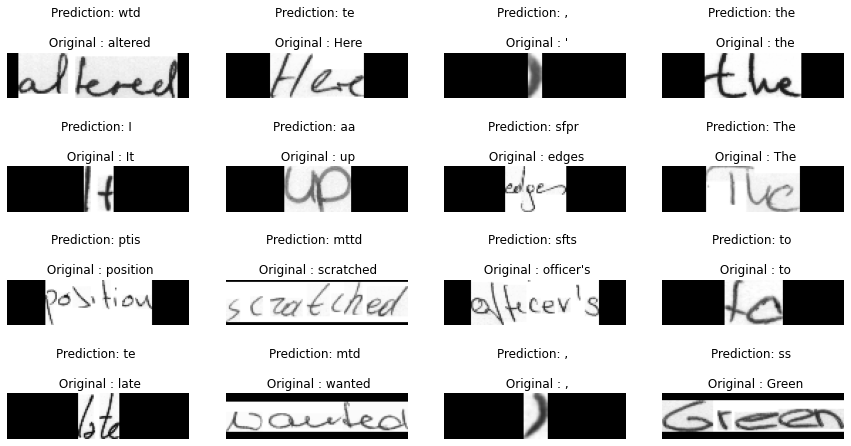

In [ ]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    # print(batch["label"])
    batch_images,batch_labels = batch["image"],batch["label"]
    print("len is : ",len(batch))
    # print(batch)
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()




In [ ]:
count = 0
for batch in test_ds:
    count = count+1
print(count)

76


In [ ]:
val_loss_list = history.history["val_loss"]
print(val_loss_list)

loss_list = history.history["loss"]
print(loss_list)
len(val_loss_list),len(loss_list)

[11.706568717956543, 9.43731689453125, 7.455863952636719, 5.697911262512207, 4.6675825119018555, 3.82129168510437, 3.3872506618499756, 3.1136553287506104, 2.895379066467285, 2.852592706680298, 2.6257147789001465, 2.666536808013916, 2.4355359077453613, 2.4286088943481445, 2.3400588035583496, 2.292853593826294, 2.288797616958618, 2.2447409629821777, 2.2066421508789062, 2.176814317703247]
[13.69798469543457, 10.576360702514648, 8.858271598815918, 7.0792460441589355, 5.718396186828613, 4.860259532928467, 4.280982494354248, 3.8947982788085938, 3.6074934005737305, 3.3743350505828857, 3.1847479343414307, 3.0204923152923584, 2.8859779834747314, 2.7686023712158203, 2.6696078777313232, 2.586311101913452, 2.502948045730591, 2.442404270172119, 2.3760952949523926, 2.3150739669799805]


(20, 20)

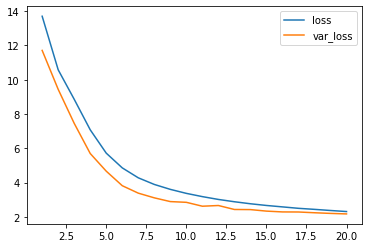

In [ ]:
# graph 
# loss vs vad_loss graph
plot_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
plt.plot(plot_list, loss_list,label="loss")
plt.plot(plot_list, val_loss_list,label="var_loss")
plt.legend()
# plt.show()

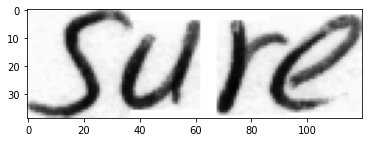

In [ ]:
# input_img = plt.imread("data/words/e04/e04-030/e04-030-04-08.png")
# input_img

# ppi = preprocess_image("data/words/e04/e04-030/e04-030-04-08.png")
# # ppi

# plt.imread(ppi)
import matplotlib.image as mpimg 

input_img = mpimg.imread('data/words/e04/e04-030/e04-030-04-08.png') 
plt.imshow(input_img,cmap="gray")

# img_size_custom=(image_width, image_height)
# image = distortion_free_resize(input_img, img_size_custom)
# print(input_img.get_shape().ndims)
# plt.imshow(image)
# fig, ax = plt.subplots() 
# ax.imshow(ppi) 
# ax.axis('off') 

# def preprocess_image(image_path, img_size=(image_width, image_height)):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_png(image, 1)
#     image = distortion_free_resize(image, img_size)
#     image = tf.cast(image, tf.float32) / 255.0
#     return image

# preds = prediction_model.predict(input_img)
# pred_texts = decode_batch_predictions(preds)
# print(pred_texts)
# img = tf.image.flip_left_right(input_img)
# img = tf.transpose(img, perm=[1, 0, 2])
# img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
# img = img[:, :, 0]
 
# plt.show() 

To get better results the model should be trained for at least 50 epochs.

## Final remarks

* The `prediction_model` is fully compatible with TensorFlow Lite. If you are interested,
you can use it inside a mobile application. You may find
[this notebook](https://github.com/tulasiram58827/ocr_tflite/blob/main/colabs/captcha_ocr_tflite.ipynb)
to be useful in this regard.
* Not all the training examples are perfectly aligned as observed in this example. This
can hurt model performance for complex sequences. To this end, we can leverage
Spatial Transformer Networks ([Jaderberg et al.](https://arxiv.org/abs/1506.02025))
that can help the model learn affine transformations that maximize its performance.